In [17]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

Importar funciones personalizadas

In [18]:
%run pandas-missing-extension.ipynb

In [19]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

In [20]:
airquality_df = (
    # Carga el conjunto de datos 'airquality' desde el paquete R usando statsmodels
    sm.datasets.get_rdataset("airquality")
    .data # Accede al DataFrame que contiene los datos del conjunto de datos 'airquality'
    # Limpia los nombres de las columnas, convirtiéndolos a formato 'snake_case'
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)     # Añade una nueva columna llamada 'year' con el valor constante 1973 para todas las filas
    # Crea una nueva columna 'date' a partir de las columnas 'year', 'month' y 'day'
    # La columna 'date' se convierte a tipo datetime usando 'pd.to_datetime'
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")     # Ordena el DataFrame por la columna 'date' en orden ascendente
    .set_index("date") # Establece la columna 'date' como el índice del DataFrame
)

airquality_df

c:\Users\Pc\anaconda3\envs\MDImputacion\lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)


,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [21]:
smf.ols(
        formula="temp ~ ozone",
        data = airquality_df
        ).fit().summary().tables[0]

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Fri, 23 Aug 2024",Prob (F-statistic):,2.93e-18
Time:,11:13:26,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


Ejecutando la eliminacion de nhanes

c:\Users\Pc\anaconda3\envs\MDImputacion\lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
c:\Users\Pc\anaconda3\envs\MDImputacion\lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


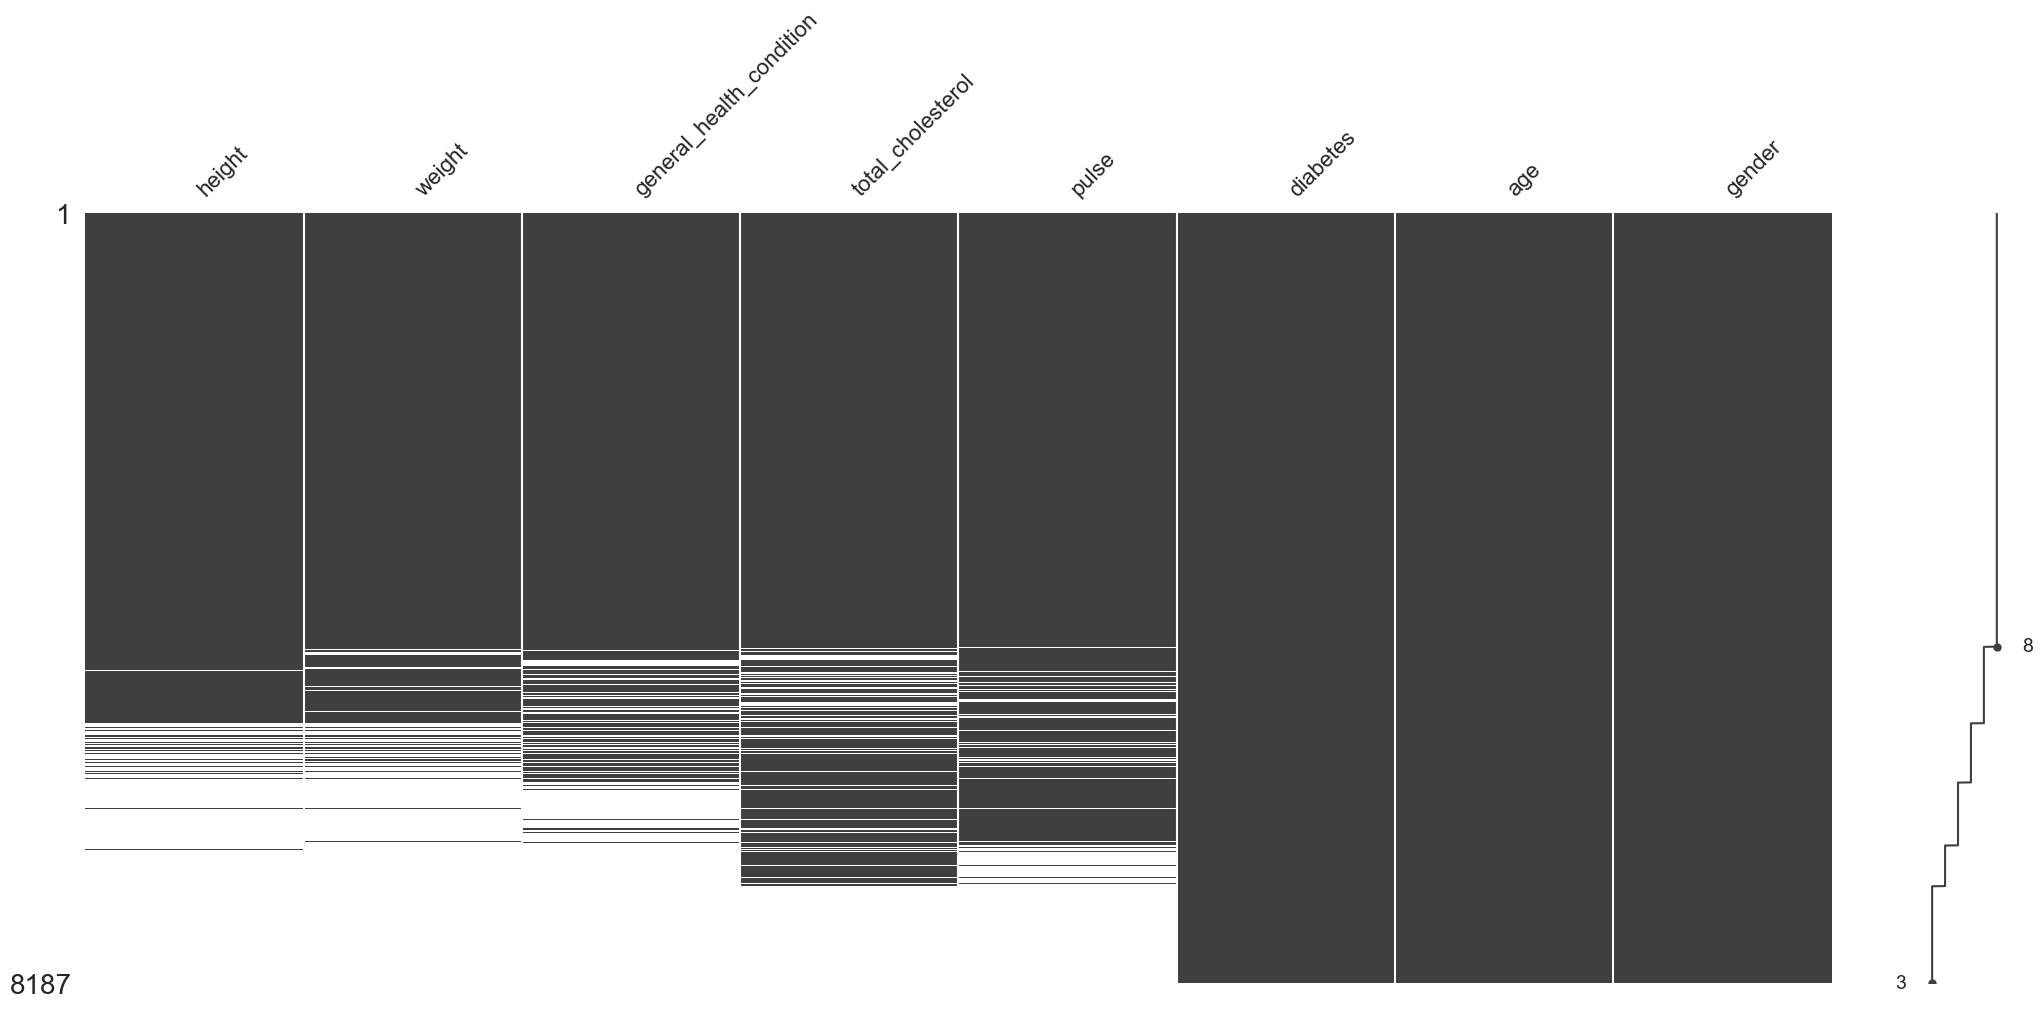

c:\Users\Pc\anaconda3\envs\MDImputacion\lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
c:\Users\Pc\anaconda3\envs\MDImputacion\lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

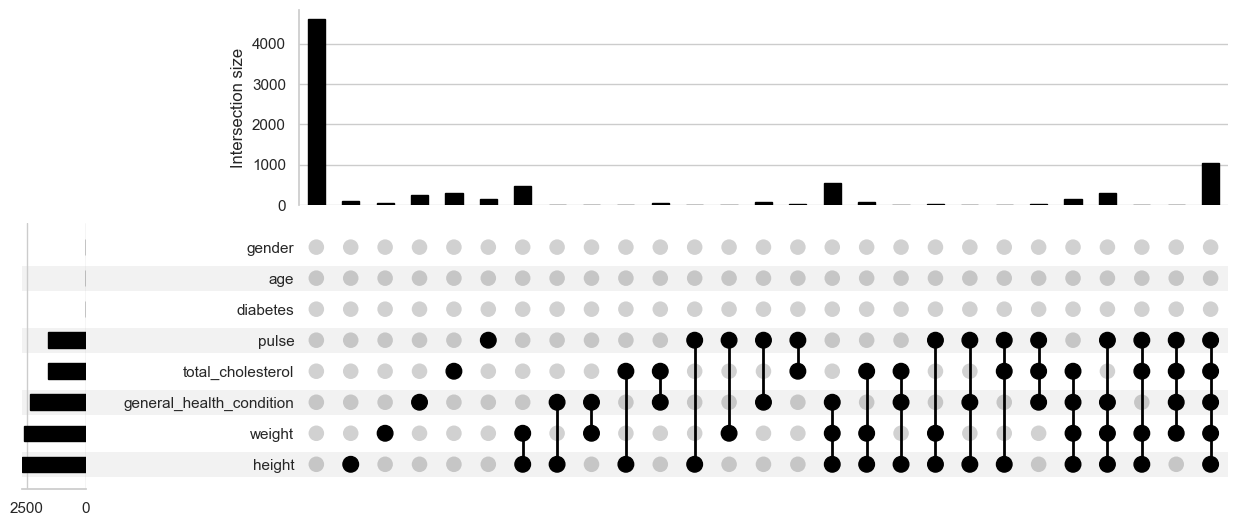

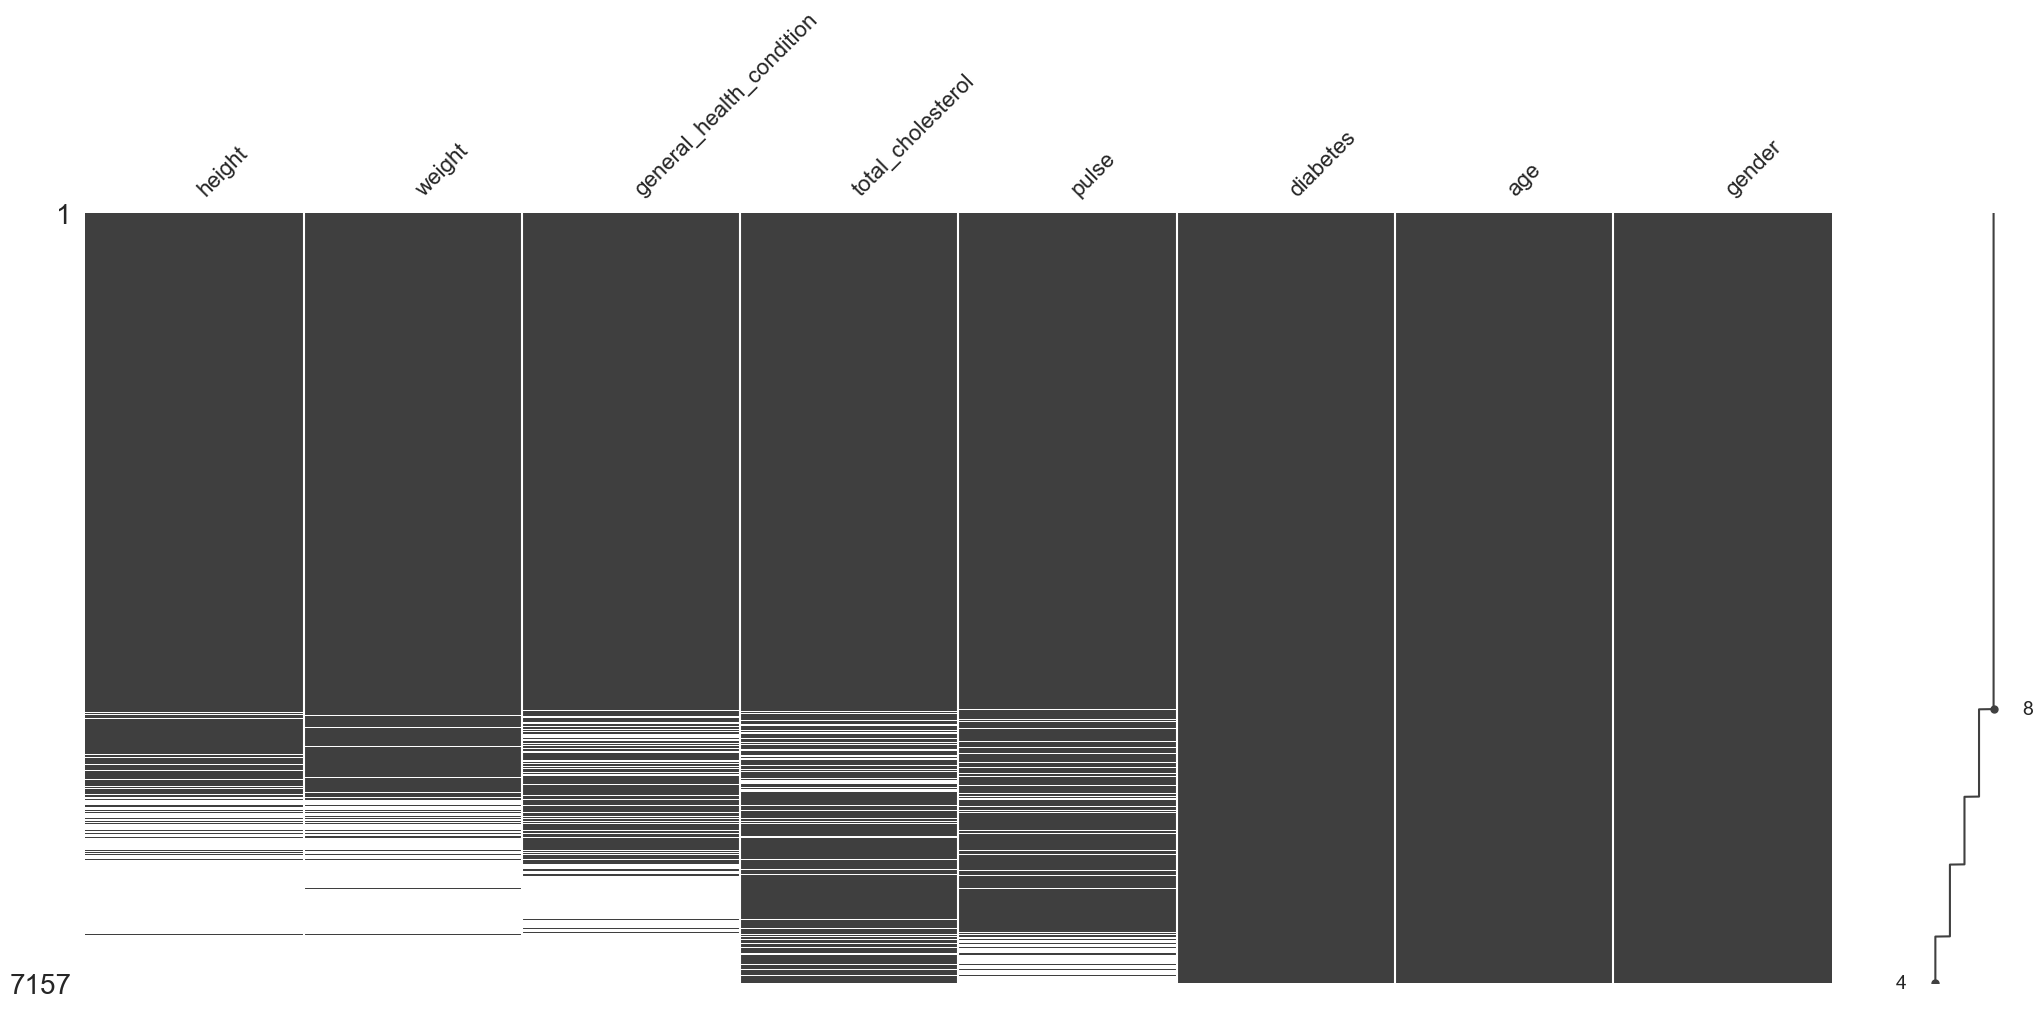

In [22]:
%run nhanes.ipynb

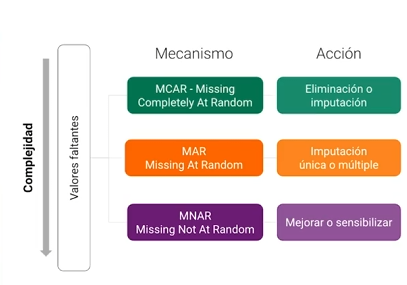

two-sided: las medias de las distribuciones subyacentes a las muestras son desiguales.
less: la media de la distribución subyacente a la primera muestra es menor que la media de la distribución subyacente a la segunda muestra.
greater: la media de la distribución subyacente a la primera muestra es mayor que la media de la distribución subyacente a la segunda muestra.

In [23]:
# Asignamos las variables female_weight y male_weight para almacenar los pesos de mujeres y hombres
female_weight, male_weight = (
    nhanes_df  # DataFrame original
    .select_columns("gender", "weight")  # Seleccionamos las columnas 'gender' y 'weight'
    .transform_column("weight", lambda x: x.isna(), elementwise=False)  # Identificamos valores faltantes en 'weight'
    .groupby("gender")  # Agrupamos por la columna 'gender'
    .weight  # Accedemos a la columna 'weight' en los grupos
    .pipe(
        lambda df: (
            df.get_group("Female"),  # Extraemos los pesos para 'Female'
            df.get_group("Male")  # Extraemos los pesos para 'Male'
        )
    )
)

# Realizamos un test t de comparación de medias entre los pesos de mujeres y hombres
scipy.stats.ttest_ind(
    a = female_weight,  # Pesos de mujeres
    b = male_weight,  # Pesos de hombres
    alternative="two-sided"  # Test bilateral para detectar diferencias en ambas direcciones
)


c:\Users\Pc\anaconda3\envs\MDImputacion\lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


TtestResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239, df=7155.0)

c:\Users\Pc\anaconda3\envs\MDImputacion\lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


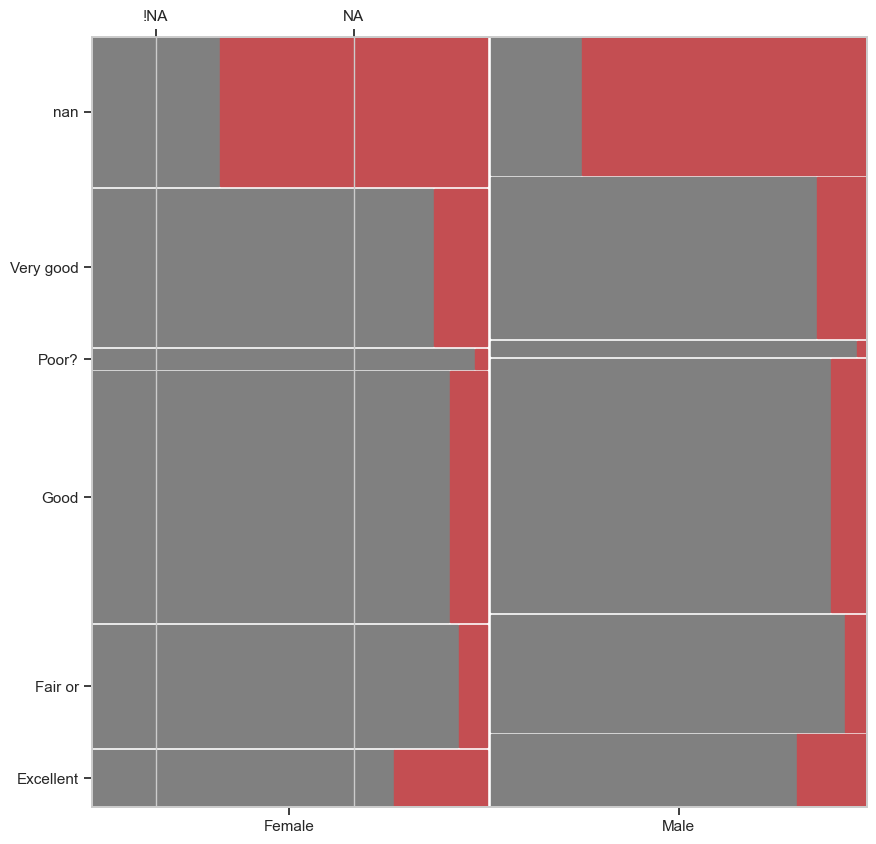

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))

(
    nhanes_df.select_columns("weight", "general_health_condition", "gender")
    .assign(weight=lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"]))
    .groupby(
        ["gender", "general_health_condition", "weight"], dropna=False, as_index=True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data=df,
            properties=lambda key: {"color": "r" if "NA" in key else "gray"},
            ax=ax,
            horizontal=True,
            axes_label=True,
            title="",
            labelizer=lambda key: "",
        )
    )
)

ax.grid(False)

In [25]:
nhanes_transformed_df = nhanes_df.copy(deep=True)

In [26]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [["Male"],  ["Female"], ["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [27]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [28]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [29]:
encoder.inverse_transform([[1], [0], [0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

Encontrar variables categoricas


In [30]:
categorical_columns=nhanes_df.select_dtypes(include=[object,"category"]).columns

In [31]:
categorical_transformer=sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(),categorical_columns),
    remainder="passthrough"
)

In [38]:
mhanes_transformrd_df=(
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out(),
        index=nhanes_df.index
    )
    .rename_columns(
        function = lambda x:x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x:x.removeprefix("remainder__")
    )
)
mhanes_transformrd_df

c:\Users\Pc\anaconda3\envs\MDImputacion\lib\site-packages\pandas_flavor\register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


Imputacion one-hot encoding

In [40]:
nhanes_transformed_df2=nhanes_df.copy(deep=True)

In [ ]:
Pandas